# Import all the required libraries

---



In [1]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf

In [24]:
# GPU Configuration
import tensorflow as tf

# Check if GPU is available
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Configure GPU memory growth to avoid memory allocation issues
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Physical GPUs: {len(gpus)}, Logical GPUs: {len(logical_gpus)}")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Set mixed precision for better GPU performance
tf.keras.mixed_precision.set_global_policy('mixed_float16')

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
Physical devices cannot be modified after being initialized
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


# Define start day to fetch the dataset from the yahoo finance library

---



In [2]:


START = "2010-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

# Define a function to load the dataset

def load_data(ticker):
    data = yf.download(ticker, START, TODAY)
    data.reset_index(inplace=True)
    return data

In [3]:
data = load_data('TCS.NS')
df=data
df.head()

C:\Users\tumur\AppData\Local\Temp\ipykernel_35376\1794888428.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, START, TODAY)
[*********************100%***********************]  1 of 1 completed



Price,Date,Close,High,Low,Open,Volume
Ticker,,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS
0,2010-01-04,282.906830,285.635592,281.928225,284.092416,1963682
1,2010-01-05,282.982239,285.880379,280.987423,284.167849,2014488
2,2010-01-06,276.583679,283.113906,275.887383,282.982159,3349176
3,2010-01-07,268.886627,278.296153,267.606922,276.828258,6474892
4,2010-01-08,263.391571,270.429904,262.149518,269.488951,6048178


In [5]:
# Check current columns and remove any unnecessary ones
print("Current columns:", df.columns.tolist())

# Only drop Date if it exists, Adj Close might already be removed
columns_to_drop = []
if 'Date' in df.columns:
    columns_to_drop.append('Date')
if 'Adj Close' in df.columns:
    columns_to_drop.append('Adj Close')

if columns_to_drop:
    df = df.drop(columns_to_drop, axis=1)
    print(f"Dropped columns: {columns_to_drop}")

print("Final columns:", df.columns.tolist())
df.head()

Current columns: [('Date', ''), ('Close', 'TCS.NS'), ('High', 'TCS.NS'), ('Low', 'TCS.NS'), ('Open', 'TCS.NS'), ('Volume', 'TCS.NS')]
Dropped columns: ['Date']
Final columns: [('Close', 'TCS.NS'), ('High', 'TCS.NS'), ('Low', 'TCS.NS'), ('Open', 'TCS.NS'), ('Volume', 'TCS.NS')]


C:\Users\tumur\AppData\Local\Temp\ipykernel_35376\2879076813.py:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df = df.drop(columns_to_drop, axis=1)


Price,Close,High,Low,Open,Volume
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS
0,282.906830,285.635592,281.928225,284.092416,1963682
1,282.982239,285.880379,280.987423,284.167849,2014488
2,276.583679,283.113906,275.887383,282.982159,3349176
3,268.886627,278.296153,267.606922,276.828258,6474892
4,263.391571,270.429904,262.149518,269.488951,6048178


In [8]:
# Reload and fix the data properly
data = load_data('TCS.NS')

# Check the structure
print("Original data structure:")
print(f"Columns: {data.columns.tolist()}")
print(f"Shape: {data.shape}")

# Reset index to make Date a column and rename properly
df = data.copy()

print("\nCleaned data structure:")
print(f"Columns: {df.columns.tolist()}")
print(f"Shape: {df.shape}")
df.head()

C:\Users\tumur\AppData\Local\Temp\ipykernel_35376\1794888428.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, START, TODAY)
[*********************100%***********************]  1 of 1 completed

Original data structure:
Columns: [('Date', ''), ('Close', 'TCS.NS'), ('High', 'TCS.NS'), ('Low', 'TCS.NS'), ('Open', 'TCS.NS'), ('Volume', 'TCS.NS')]
Shape: (3822, 6)

Cleaned data structure:
Columns: [('Date', ''), ('Close', 'TCS.NS'), ('High', 'TCS.NS'), ('Low', 'TCS.NS'), ('Open', 'TCS.NS'), ('Volume', 'TCS.NS')]
Shape: (3822, 6)


Price,Date,Close,High,Low,Open,Volume
Ticker,,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS
0,2010-01-04,282.906830,285.635592,281.928225,284.092416,1963682
1,2010-01-05,282.982239,285.880379,280.987423,284.167849,2014488
2,2010-01-06,276.583679,283.113906,275.887383,282.982159,3349176
3,2010-01-07,268.886627,278.296153,267.606922,276.828258,6474892
4,2010-01-08,263.391571,270.429904,262.149518,269.488951,6048178


In [9]:
# Fix the MultiIndex column structure
# Drop the MultiIndex and use simple column names
df.columns = df.columns.droplevel(1)  # Remove the second level (ticker names)

print("After dropping MultiIndex level:")
print(f"Columns: {df.columns.tolist()}")

# Now we have proper single-level columns
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]

print("Final cleaned dataframe:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Data types:\n{df.dtypes}")
df.head()

After dropping MultiIndex level:
Columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
Final cleaned dataframe:
Shape: (3822, 6)
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
Data types:
Price
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object


Price,Date,Open,High,Low,Close,Volume
0,2010-01-04,284.092416,285.635592,281.928225,282.906830,1963682
1,2010-01-05,284.167849,285.880379,280.987423,282.982239,2014488
2,2010-01-06,282.982159,283.113906,275.887383,276.583679,3349176
3,2010-01-07,276.828258,278.296153,267.606922,268.886627,6474892
4,2010-01-08,269.488951,270.429904,262.149518,263.391571,6048178


# Adding Technical Indicators to the Dataset

We'll add the following technical indicators:
- Moving Averages (20, 50, 100, 200 days)
- RSI (Relative Strength Index)
- MACD (Moving Average Convergence Divergence)

---

In [10]:
# Function to calculate RSI
def calculate_rsi(data, window=14):
    """
    Calculate Relative Strength Index (RSI)
    """
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate MACD
def calculate_macd(data, fast=12, slow=26, signal=9):
    """
    Calculate MACD (Moving Average Convergence Divergence)
    """
    ema_fast = data.ewm(span=fast).mean()
    ema_slow = data.ewm(span=slow).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=signal).mean()
    histogram = macd_line - signal_line
    
    return macd_line, signal_line, histogram

In [11]:
# Calculate Moving Averages
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['MA_100'] = df['Close'].rolling(window=100).mean()
df['MA_200'] = df['Close'].rolling(window=200).mean()

# Calculate RSI
df['RSI'] = calculate_rsi(df['Close'])

# Calculate MACD
df['MACD'], df['MACD_Signal'], df['MACD_Histogram'] = calculate_macd(df['Close'])

# Display the updated dataframe with technical indicators
print("Dataset with Technical Indicators:")
print(f"Shape: {df.shape}")
df.head()

Dataset with Technical Indicators:
Shape: (3822, 14)


Price,Date,Open,High,Low,Close,Volume,MA_20,MA_50,MA_100,MA_200,RSI,MACD,MACD_Signal,MACD_Histogram
0,2010-01-04,284.092416,285.635592,281.928225,282.906830,1963682,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,2010-01-05,284.167849,285.880379,280.987423,282.982239,2014488,NaN,NaN,NaN,NaN,NaN,0.001692,0.000940,0.000752
2,2010-01-06,282.982159,283.113906,275.887383,276.583679,3349176,NaN,NaN,NaN,NaN,NaN,-0.196263,-0.079881,-0.116382
3,2010-01-07,276.828258,278.296153,267.606922,268.886627,6474892,NaN,NaN,NaN,NaN,NaN,-0.559386,-0.242315,-0.317071
4,2010-01-08,269.488951,270.429904,262.149518,263.391571,6048178,NaN,NaN,NaN,NaN,NaN,-0.963586,-0.456877,-0.506709


In [12]:
# Check for missing values after adding technical indicators
print("Missing values in each column:")
print(df.isnull().sum())

# Drop rows with NaN values (mainly from moving averages and technical indicators)
df_clean = df.dropna()
print(f"\nDataset shape after removing NaN values: {df_clean.shape}")

# Update df to use the cleaned version
df = df_clean.copy()
df.head()

Missing values in each column:
Price
Date                0
Open                0
High                0
Low                 0
Close               0
Volume              0
MA_20              19
MA_50              49
MA_100             99
MA_200            199
RSI                13
MACD                0
MACD_Signal         0
MACD_Histogram      0
dtype: int64

Dataset shape after removing NaN values: (3623, 14)


Price,Date,Open,High,Low,Close,Volume,MA_20,MA_50,MA_100,MA_200,RSI,MACD,MACD_Signal,MACD_Histogram
199,2010-10-19,373.368093,375.421247,366.562290,367.950073,2200912,360.851518,343.318433,321.920015,305.987465,60.787455,7.759381,7.880182,-0.120802
200,2010-10-20,366.714401,372.797791,363.558646,366.239136,2206638,361.383812,344.069350,322.792820,306.404127,58.340993,7.290641,7.762274,-0.471633
201,2010-10-21,370.345412,377.873604,368.805559,374.964996,3752354,362.426547,345.043072,323.696089,306.864041,55.973771,7.536390,7.717097,-0.180707
202,2010-10-22,388.576591,398.994407,388.576591,395.496429,9610404,364.484444,346.463161,324.762404,307.458604,66.607608,9.280879,8.029854,1.251025
203,2010-10-25,396.560997,407.948325,394.355750,405.667053,5156316,367.133572,348.079439,325.930803,308.142506,71.195016,11.353210,8.694525,2.658685


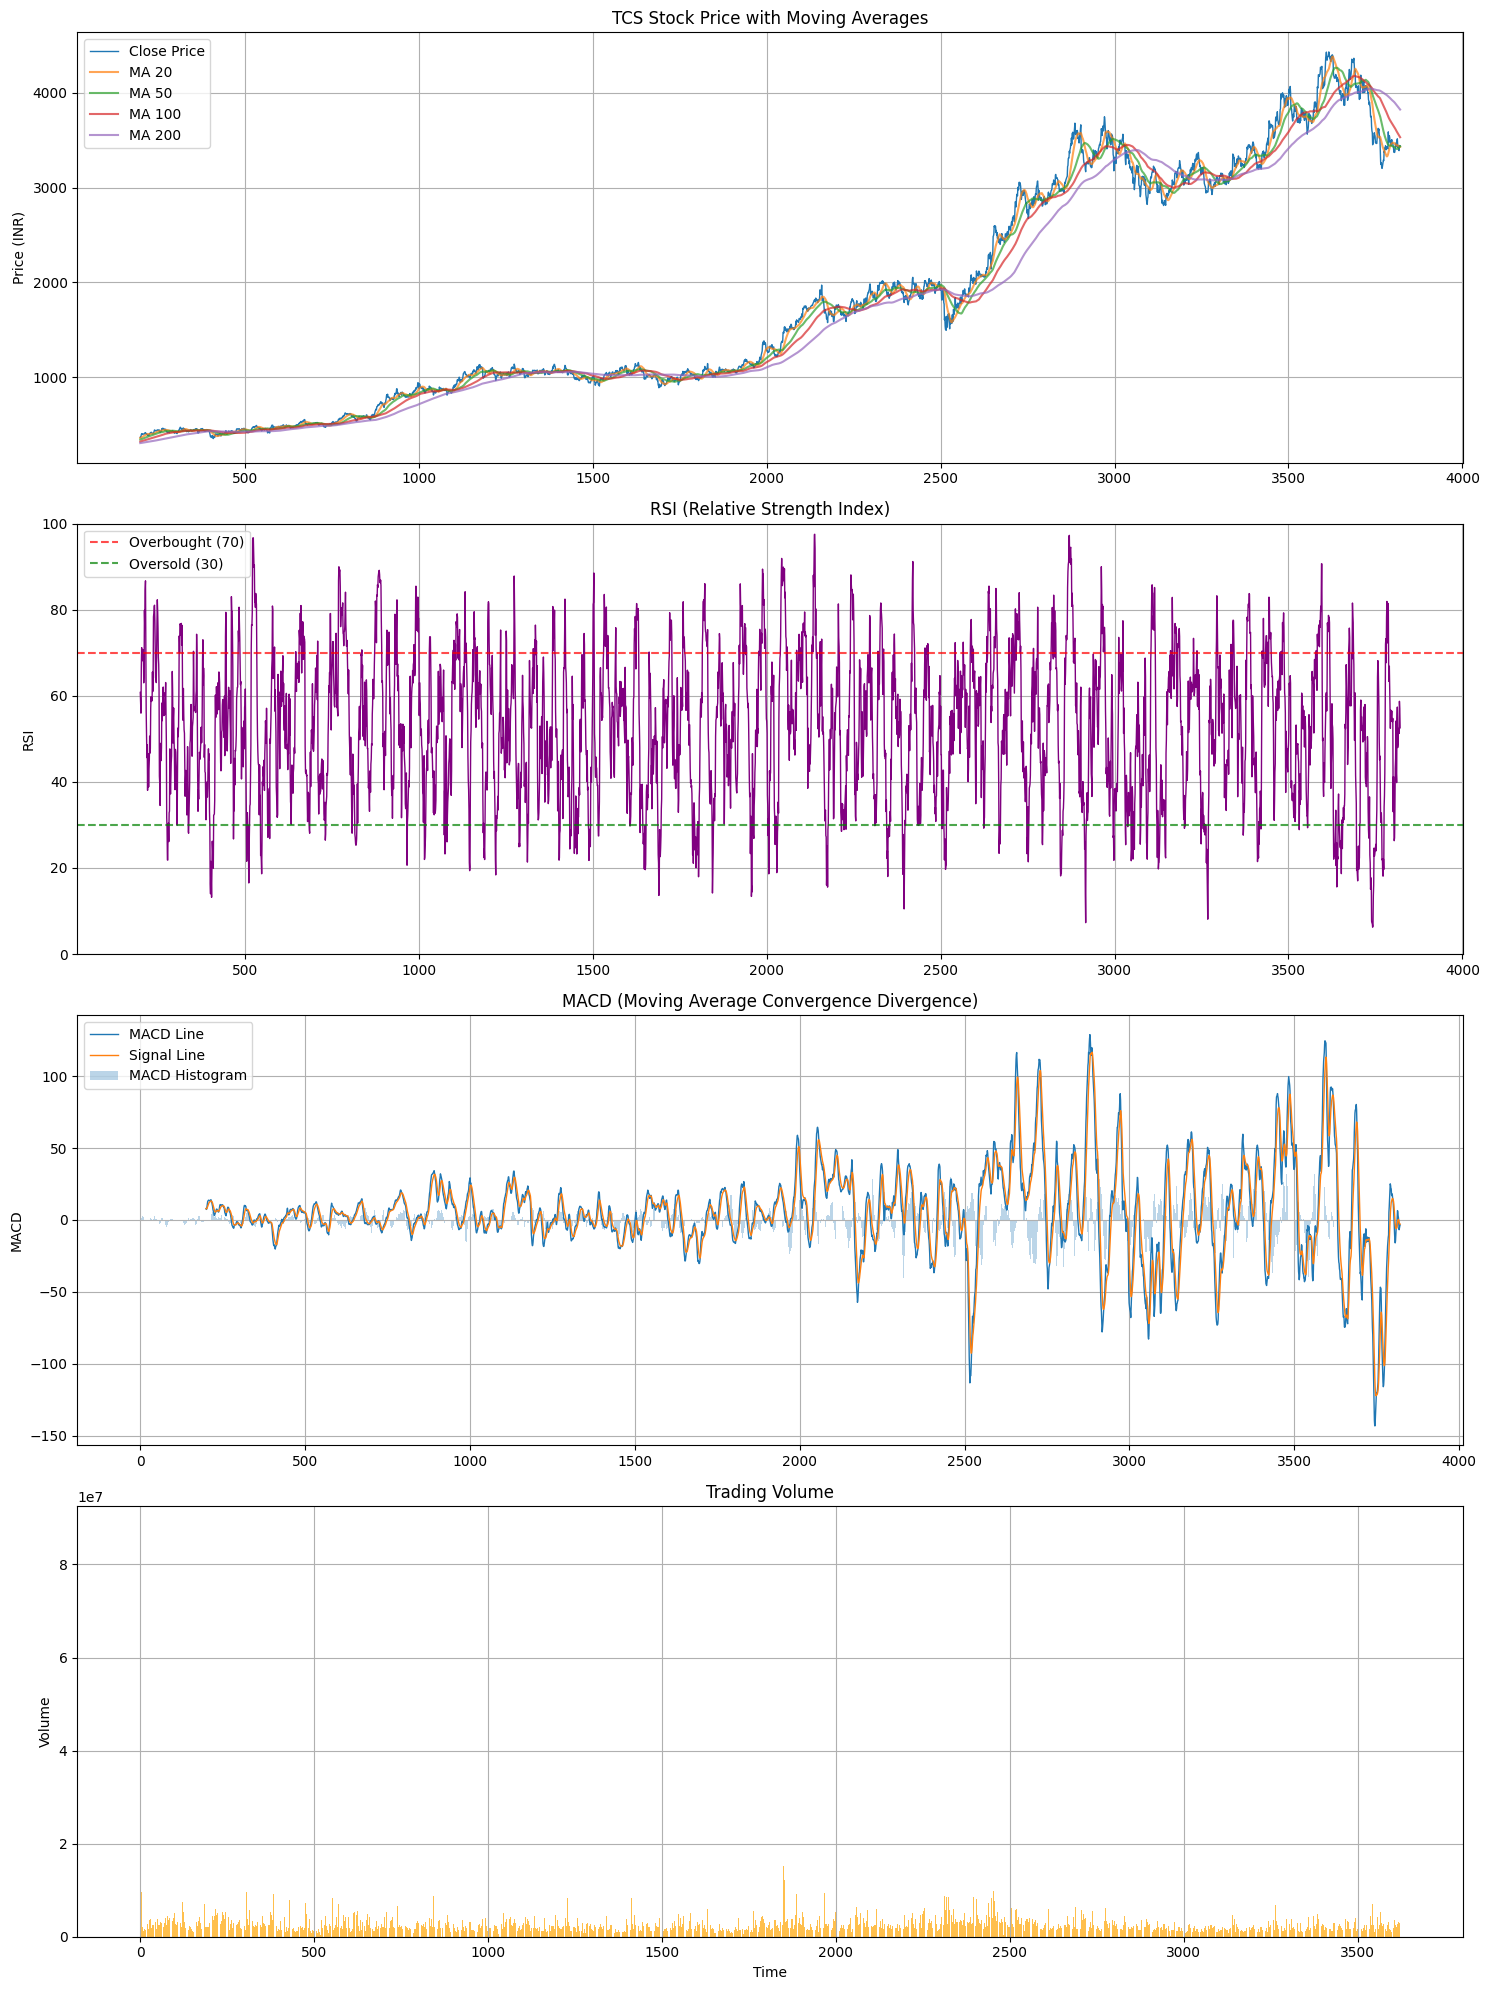

In [13]:
# Visualize Technical Indicators
fig, axes = plt.subplots(4, 1, figsize=(15, 20))

# Plot 1: Close price with Moving Averages
axes[0].plot(df['Close'], label='Close Price', linewidth=1)
axes[0].plot(df['MA_20'], label='MA 20', alpha=0.7)
axes[0].plot(df['MA_50'], label='MA 50', alpha=0.7)
axes[0].plot(df['MA_100'], label='MA 100', alpha=0.7)
axes[0].plot(df['MA_200'], label='MA 200', alpha=0.7)
axes[0].set_title('TCS Stock Price with Moving Averages')
axes[0].set_ylabel('Price (INR)')
axes[0].legend()
axes[0].grid(True)

# Plot 2: RSI
axes[1].plot(df['RSI'], color='purple', linewidth=1)
axes[1].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought (70)')
axes[1].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold (30)')
axes[1].set_title('RSI (Relative Strength Index)')
axes[1].set_ylabel('RSI')
axes[1].set_ylim(0, 100)
axes[1].legend()
axes[1].grid(True)

# Plot 3: MACD
axes[2].plot(df['MACD'], label='MACD Line', linewidth=1)
axes[2].plot(df['MACD_Signal'], label='Signal Line', linewidth=1)
axes[2].bar(range(len(df)), df['MACD_Histogram'], label='MACD Histogram', alpha=0.3)
axes[2].set_title('MACD (Moving Average Convergence Divergence)')
axes[2].set_ylabel('MACD')
axes[2].legend()
axes[2].grid(True)

# Plot 4: Volume
axes[3].bar(range(len(df)), df['Volume'], alpha=0.7, color='orange')
axes[3].set_title('Trading Volume')
axes[3].set_ylabel('Volume')
axes[3].set_xlabel('Time')
axes[3].grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Remove Date column as it's not needed for training
df = df.drop('Date', axis=1)

print("Final dataset for training:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Final dataset for training:
Shape: (3623, 13)
Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'MA_20', 'MA_50', 'MA_100', 'MA_200', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram']


Price,Open,High,Low,Close,Volume,MA_20,MA_50,MA_100,MA_200,RSI,MACD,MACD_Signal,MACD_Histogram
199,373.368093,375.421247,366.562290,367.950073,2200912,360.851518,343.318433,321.920015,305.987465,60.787455,7.759381,7.880182,-0.120802
200,366.714401,372.797791,363.558646,366.239136,2206638,361.383812,344.069350,322.792820,306.404127,58.340993,7.290641,7.762274,-0.471633
201,370.345412,377.873604,368.805559,374.964996,3752354,362.426547,345.043072,323.696089,306.864041,55.973771,7.536390,7.717097,-0.180707
202,388.576591,398.994407,388.576591,395.496429,9610404,364.484444,346.463161,324.762404,307.458604,66.607608,9.280879,8.029854,1.251025
203,396.560997,407.948325,394.355750,405.667053,5156316,367.133572,348.079439,325.930803,308.142506,71.195016,11.353210,8.694525,2.658685


Visualizing Closing Price

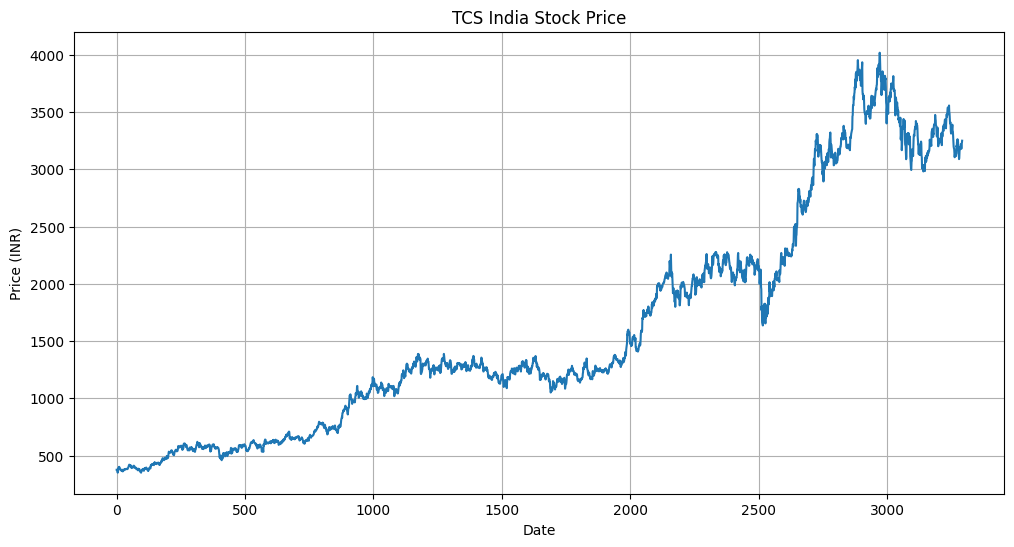

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title("TCS India Stock Price")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.grid(True)
plt.show()

In [6]:
df

,Open,High,Low,Close,Volume
0,377.399994,379.450012,374.524994,375.825012,1963682
1,377.500000,379.774994,373.274994,375.924988,2014488
2,375.924988,376.100006,366.500000,367.424988,3349176
3,367.750000,369.700012,355.500000,357.200012,6474892
4,358.000000,359.250000,348.250000,349.899994,6048178
...,...,...,...,...,...
3288,3235.000000,3235.000000,3210.000000,3219.399902,2321159
3289,3216.000000,3216.000000,3173.149902,3179.899902,2468285
3290,3180.149902,3224.449951,3178.000000,3220.699951,1953253
3291,3220.000000,3244.000000,3210.050049,3230.699951,1710027


# Plotting moving averages of 100 day

---



In [7]:
ma100 = df.Close.rolling(100).mean()
ma100

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
3288    3305.993005
3289    3303.533005
3290    3301.886504
3291    3300.387502
3292    3299.388003
Name: Close, Length: 3293, dtype: float64

Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days')

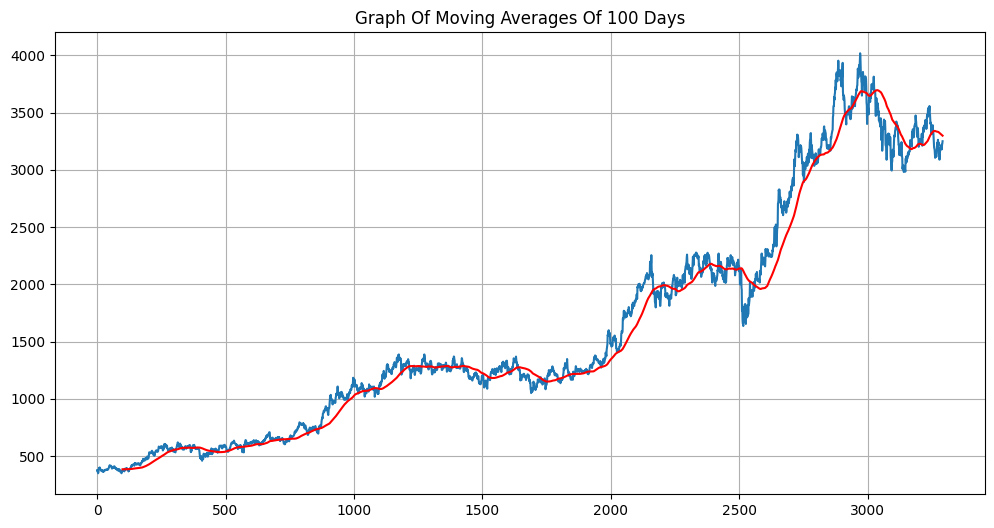

In [8]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.grid(True)
plt.title('Graph Of Moving Averages Of 100 Days')

# Defining 200 days moving averages and plotting comparision graph with 100 days moving averages

---



In [9]:
ma200 = df.Close.rolling(200).mean()
ma200

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
           ...     
3288    3253.645248
3289    3253.217498
3290    3253.751997
3291    3254.481997
3292    3255.541248
Name: Close, Length: 3293, dtype: float64

Text(0.5, 1.0, 'Comparision Of 100 Days And 200 Days Moving Averages')

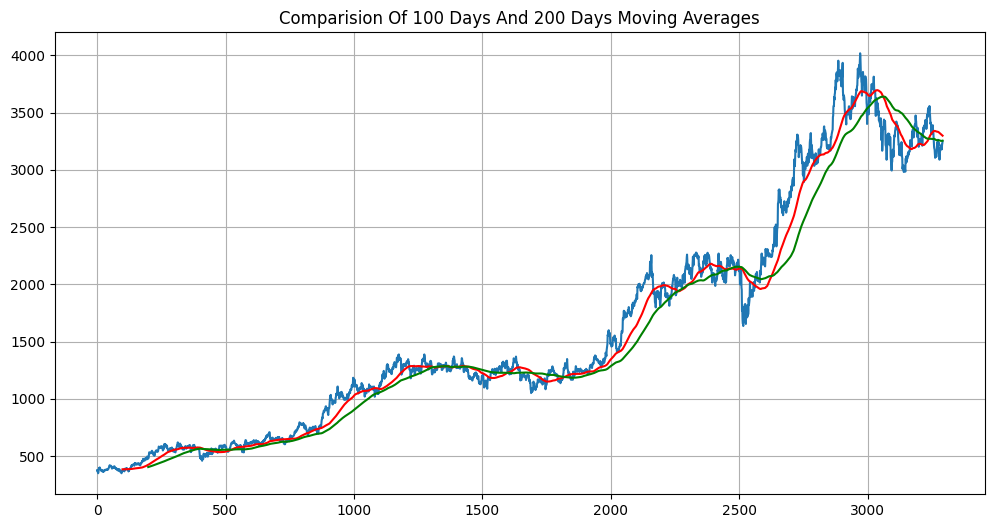

In [10]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.grid(True)
plt.title('Comparision Of 100 Days And 200 Days Moving Averages')

In [11]:
df.shape

(3293, 5)

# Spliting the dataset into training (70%) and testing (30%) set

In [15]:
# Splitting data into training and testing
# Using the cleaned dataset with technical indicators

train = pd.DataFrame(df[0:int(len(df)*0.70)])
test = pd.DataFrame(df[int(len(df)*0.70): int(len(df))])

print(f"Training set shape: {train.shape}")
print(f"Testing set shape: {test.shape}")
print(f"Features in dataset: {list(df.columns)}")

Training set shape: (2536, 13)
Testing set shape: (1087, 13)
Features in dataset: ['Open', 'High', 'Low', 'Close', 'Volume', 'MA_20', 'MA_50', 'MA_100', 'MA_200', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram']


In [13]:
train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,377.399994,379.450012,374.524994,375.825012,289.802155,1963682
1,2010-01-05,377.500000,379.774994,373.274994,375.924988,289.879333,2014488
2,2010-01-06,375.924988,376.100006,366.500000,367.424988,283.325012,3349176
3,2010-01-07,367.750000,369.700012,355.500000,357.200012,275.440186,6474892
4,2010-01-08,358.000000,359.250000,348.250000,349.899994,269.811127,6048178


In [14]:
test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
2305,2019-05-13,2133.000000,2167.000000,2121.649902,2128.750000,1938.281494,1701744
2306,2019-05-14,2135.000000,2159.800049,2072.350098,2092.350098,1905.138428,2456110
2307,2019-05-15,2097.000000,2124.000000,2084.500000,2095.399902,1907.915405,2346876
2308,2019-05-16,2096.000000,2124.000000,2077.050049,2108.750000,1920.071045,1946529
2309,2019-05-17,2112.600098,2135.000000,2090.000000,2095.449951,1907.960938,1947908


# Using MinMax scaler for normalization of the dataset

---



In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# Select features for training (including technical indicators)
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA_20', 'MA_50', 'MA_100', 'MA_200', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram']
print(f"Selected features for training: {feature_columns}")
print(f"Number of features: {len(feature_columns)}")

Selected features for training: ['Open', 'High', 'Low', 'Close', 'Volume', 'MA_20', 'MA_50', 'MA_100', 'MA_200', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Histogram']
Number of features: 13


In [17]:
# Extract training and testing data with all features
train_data = train[feature_columns].values
test_data = test[feature_columns].values

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Training data shape: (2536, 13)
Testing data shape: (1087, 13)


In [18]:
data_training_array = scaler.fit_transform(train_data)
print(f"Scaled training data shape: {data_training_array.shape}")
data_training_array

Scaled training data shape: (2536, 13)


array([[0.00690486, 0.00630232, 0.00712791, ..., 0.52710937, 0.51168095,
        0.56839685],
       [0.00444341, 0.00534069, 0.00600815, ..., 0.52506908, 0.51108118,
        0.56347143],
       [0.00578666, 0.00720123, 0.00796419, ..., 0.52613876, 0.51085138,
        0.56755582],
       ...,
       [0.96618962, 0.95835266, 0.93845357, ..., 0.840673  , 0.96814478,
        0.3199348 ],
       [0.92856721, 0.94078918, 0.91919551, ..., 0.79440272, 0.93920264,
        0.25057431],
       [0.95386488, 0.96077414, 0.9556786 , ..., 0.77528786, 0.91158129,
        0.26515557]])

In [19]:
x_train = []
y_train = [] 

# Create sequences with all features for X and close price for y
for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])  # All features for past 100 days
    y_train.append(data_training_array[i, 3])      # Close price (index 3 in feature_columns)

x_train, y_train = np.array(x_train), np.array(y_train)
print(f"X_train shape: {x_train.shape}")
print(f"Y_train shape: {y_train.shape}") 

X_train shape: (2436, 100, 13)
Y_train shape: (2436,)


In [19]:
x_train.shape

(2205, 100, 1)

# ML Model (LSTM)

---



In [20]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [25]:
# Build GPU-optimized LSTM model with cuDNN-compatible settings
model = Sequential()

# Use tanh activation for cuDNN compatibility (faster on GPU)
model.add(LSTM(units = 50, activation = 'tanh', recurrent_activation='sigmoid', 
               return_sequences=True, input_shape = (x_train.shape[1], x_train.shape[2]),
               name='lstm_1'))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'tanh', recurrent_activation='sigmoid',
               return_sequences=True, name='lstm_2'))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'tanh', recurrent_activation='sigmoid',
               return_sequences=True, name='lstm_3'))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'tanh', recurrent_activation='sigmoid',
               name='lstm_4'))
model.add(Dropout(0.5))

# Use float32 for final layer due to mixed precision
model.add(Dense(units = 1, dtype='float32', name='dense_output'))

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100, 50)           12800     
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_5 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_6 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_4 (LSTM)               (None, 120)              

# Training the model

---



In [27]:
# Compile model with GPU-optimized settings
import tensorflow as tf

# Use mixed precision compatible loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

# Add callbacks for better training
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001
)

# Train with GPU acceleration and callbacks
print("Starting training on GPU...")
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,  # Optimal batch size for GPU
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Starting training on GPU...
Epoch 1/100
77/77 [==============================] - 7s 29ms/step - loss: 0.0087 - mean_absolute_error: 0.0590 - lr: 0.0010
Epoch 2/100
77/77 [==============================] - 7s 29ms/step - loss: 0.0087 - mean_absolute_error: 0.0590 - lr: 0.0010
Epoch 2/100
77/77 [==============================] - 2s 28ms/step - loss: 0.0029 - mean_absolute_error: 0.0376 - lr: 0.0010
Epoch 3/100
77/77 [==============================] - 2s 28ms/step - loss: 0.0029 - mean_absolute_error: 0.0376 - lr: 0.0010
Epoch 3/100
77/77 [==============================] - 2s 28ms/step - loss: 0.0029 - mean_absolute_error: 0.0375 - lr: 0.0010
Epoch 4/100
77/77 [==============================] - 2s 28ms/step - loss: 0.0029 - mean_absolute_error: 0.0375 - lr: 0.0010
Epoch 4/100
77/77 [==============================] - 2s 29ms/step - loss: 0.0032 - mean_absolute_error: 0.0379 - lr: 0.0010
Epoch 5/100
77/77 [==============================] - 2s 29ms/step - loss: 0.0032 - mean_absolute_error: 

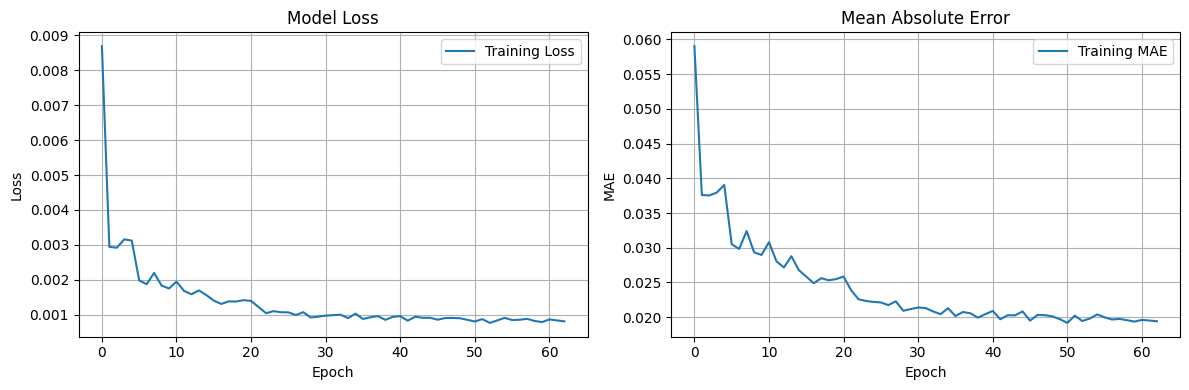

Final training loss: 0.000806
Final training MAE: 0.019407


In [28]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final training MAE: {history.history['mean_absolute_error'][-1]:.6f}")

In [24]:
model.save('keras_model.h5')

In [ ]:
test_data.shape

(988, 1)

In [ ]:
past_100_days = pd.DataFrame(train_data[-100:])  # Last 100 days from training data with all features

In [ ]:
test_df = pd.DataFrame(test_data)  # Test data with all features

**Defining the final dataset for testing by including last 100 coloums of the training dataset to get the prediction from the 1st column of the testing dataset.**

---


In [ ]:
final_df = past_100_days._append(test_df, ignore_index = True)  # Using _append instead of deprecated append

<ipython-input-28-50640d85f7a0>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_100_days.append(test_df, ignore_index = True)


In [29]:
final_df.head()

,0
0,2000.000000
1,2016.800049
2,1982.599976
3,1989.750000
4,1994.300049


In [ ]:
input_data = scaler.transform(final_df)  # Use transform instead of fit_transform for consistency
input_data

array([[0.15261459],
       [0.15966514],
       [0.14531224],
       ...,
       [0.66491104],
       [0.66910778],
       [0.67745936]])

In [31]:
input_data.shape

(1088, 1)

# Testing the model

---



In [ ]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
   x_test.append(input_data[i-100: i])     # All features for past 100 days
   y_test.append(input_data[i, 3])         # Close price (index 3 in feature_columns)

In [33]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(988, 100, 1)
(988,)


# Making prediction and plotting the graph of predicted vs actual values

---



In [34]:
# Making predictions

y_pred = model.predict(x_test)

31/31 [==============================] - 2s 56ms/step


In [35]:
y_pred.shape

(988, 1)

In [ ]:
# Get the scaling factor for close price (index 3 in feature_columns)
close_price_scaler = MinMaxScaler(feature_range=(0,1))
close_price_scaler.fit(train[['Close']])  # Fit only on close price column
scale_factor = 1/close_price_scaler.scale_[0]

print(f"Close price scale factor: {scale_factor}")

# Inverse transform the predictions and actual values
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor

print(f"Predicted prices range: {y_pred.min():.2f} - {y_pred.max():.2f}")
print(f"Actual prices range: {y_test.min():.2f} - {y_test.max():.2f}")

array([0.00041967])

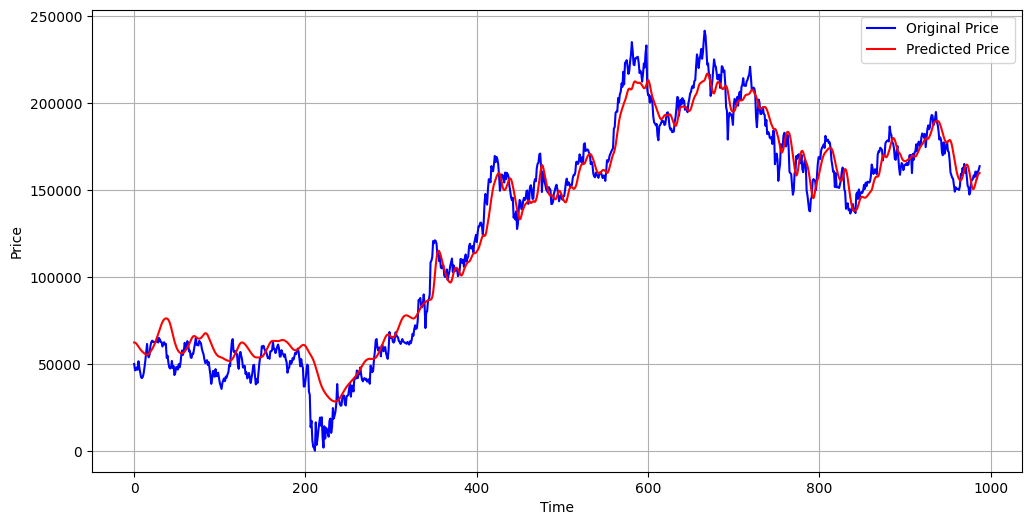

In [47]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Model evaluation

Calculation of mean absolute error

In [56]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
mae_percentage = (mae / np.mean(y_test)) * 100
print("Mean absolute error on test set: {:.2f}%".format(mae_percentage))

Mean absolute error on test set: 6.54%


Calculation of R2 score

In [49]:
from sklearn.metrics import r2_score

# Actual values
actual = y_test

# Predicted values
predicted = y_pred

# Calculate the R2 score
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.9702856476907452


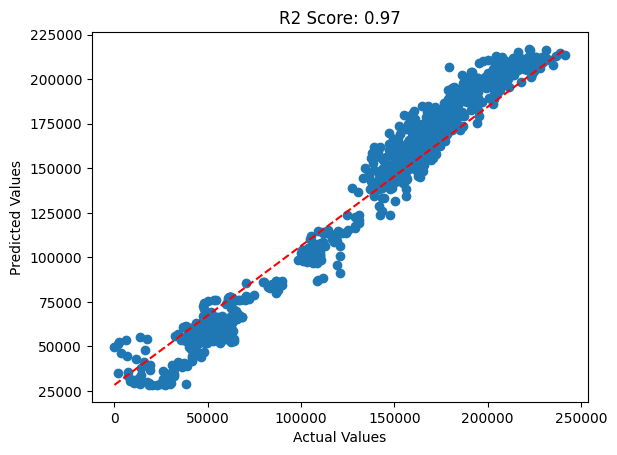

In [53]:
plt.scatter(actual, predicted)
plt.plot([min(actual), max(actual)], [min(predicted), max(predicted)], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'R2 Score: {r2:.2f}')
plt.show()